# 1. 기본 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
%cd /content/drive/MyDrive/archive/sql_2_csv

/content/drive/MyDrive/archive/sql_2_csv


In [ ]:
pwd

'/content/drive/MyDrive/archive/sql_2_csv'

In [ ]:
ls

academy.csv                              student_workbook_progress.csv
academy_log.csv                          student_workbook_revision.csv
custom_workbook_problem.csv              student_workbook_scoring.csv
problem_concept.csv                      student_worksheet.csv
problem.csv                              student_worksheet_scoring.csv
problem_curriculum_concept_cache.csv     teacher.csv
problem_curriculum_concept_cache.gsheet  workbook.csv
problem_curriculum.csv                   workbook_page.csv
public_workbook_problem.csv              workbook_problem.csv
school_workbook_problem.csv              worksheet.csv
student.csv                              worksheet_problem.csv
student_workbook.csv


## 데이터 로드

In [ ]:
student = pd.read_csv('./student.csv')
academy = pd.read_csv('./academy.csv')
academy_log = pd.read_csv('./academy_log.csv')
student_worksheet = pd.read_csv('./student_worksheet.csv')
student_worksheet_scoring = pd.read_csv('./student_worksheet_scoring.csv')

# 2. 데이터 전처리
* 굳이 다시 돌릴 필요는 없다!
* 이미 전처리 후에 저장된 것을 '3. 분석'에서 다시 가져올 것임으로!

## academy_InProgress_365(academy)

학원 운영 기간(시스템에 등록된 시점부터 지금까지)

1. academy_InProgress

2. academy_InProgress_365 <- 365일이 넘은 학원만 추출!

['academy.id', 'academy.status', 'academy.create_datetime','academy.runway']

In [ ]:
# 정식으로 서비스를 사용중인 학원에 대해서
academy_InProgress = academy[academy['status'] == 'PAY_INPROGRESS']

# 학원이 시스템상에 처음으로 가입한 날짜가 없는 경우, 그 데이터(행)를 제거
academy_InProgress = academy_InProgress.dropna(subset=['create_datetime'], how='any', axis=0)

academy_InProgress = academy_InProgress.reset_index()

# csv에서 데이터프레임으로 가져오면, 자료형이 문자열의 형태임으로 datetime으로 자료형을 변경해준다.
academy_InProgress['create_datetime'] = pd.to_datetime(academy_InProgress['create_datetime'])

In [ ]:
# 변경된 academy라고 생각하면 된다.

academy_InProgress.head()

,index,Unnamed: 0,id,status,create_datetime,runway
0,3,3,D0004,PAY_INPROGRESS,2016-06-11,2352
1,6,6,D0007,PAY_INPROGRESS,2016-05-30,2364
2,21,21,D0022,PAY_INPROGRESS,2016-07-11,2322
3,32,32,D0033,PAY_INPROGRESS,2016-07-26,2307
4,38,38,D0039,PAY_INPROGRESS,2016-08-12,2290


In [ ]:
# 새로운 'runway'열을 추가한다.(0으로 세팅)

academy_InProgress['runway'] = 0

# 이 열의 경우에 '시스템 최초 가입을로부터 지금까지의 시간간격'을 의미한다. <- 구체적으로는 day차이 일 듯!
for i in range(len(academy_InProgress)):
  academy_InProgress['runway'][i] = int(str( pd.Timestamp.today() - academy_InProgress['create_datetime'][i] ).split()[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# 사용할 열만 선택

academy_InProgress = academy_InProgress[['id', 'status', 'create_datetime','runway']]
academy_InProgress.head()

,id,status,create_datetime,runway
0,D0004,PAY_INPROGRESS,2016-06-11,2352
1,D0007,PAY_INPROGRESS,2016-05-30,2364
2,D0022,PAY_INPROGRESS,2016-07-11,2322
3,D0033,PAY_INPROGRESS,2016-07-26,2307
4,D0039,PAY_INPROGRESS,2016-08-12,2290


In [ ]:
# 시스템안에서 지금까지 사용되는 날짜가 365일 이상인 것만 추출한다.
# 이 데이터프레임을 'academy_InProgress_365'으로 정의한다.

academy_InProgress_365 = academy_InProgress[academy_InProgress['runway']>=365]
academy_InProgress_365 = academy_InProgress_365.sort_values(by = ['runway'])
academy_InProgress_365 = academy_InProgress_365.reset_index()
academy_InProgress_365 = academy_InProgress_365[['id', 'status', 'create_datetime','runway']]
academy_InProgress_365.columns = ['academy.id', 'academy.status', 'academy.create_datetime','academy.runway']

academy_InProgress_365.head()

,academy.id,academy.status,academy.create_datetime,academy.runway
0,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365
1,D13716,PAY_INPROGRESS,2021-11-18 15:02:36,365
2,D13714,PAY_INPROGRESS,2021-11-18 14:35:15,365
3,D13708,PAY_INPROGRESS,2021-11-18 10:55:38,365
4,D13696,PAY_INPROGRESS,2021-11-16 20:24:27,367


## student_current_3_3(student)

고3으로 제한해서 정보 추출

['student.id', 'student.academy_id', 'student.school_type', 'student.grade', 'student.status']

In [ ]:
# 고등학생(['school_type'] == 3)이고, 3학년(student['grade'] == 3)인 경우 <- 즉, 고3만 가져온다.

student_current_3_3 = student[(student['school_type'] == 3) & (student['grade'] == 3)]
student_current_3_3 = student_current_3_3[['id', 'academy_id', 'school_type', 'grade', 'status']]
student_current_3_3.columns = ['student.id', 'student.academy_id', 'student.school_type', 'student.grade', 'student.status']

student_current_3_3.head()

,student.id,student.academy_id,student.school_type,student.grade,student.status
0,I0,D0000,3,3,1
2,I10,D0000,3,3,1
3,I100,D0014,3,3,0
4,I1000,D0059,3,3,0
5,I10000,D0562,3,3,0


## 1. academy_student
***(academy + student)***

위의 academy_InProgress_365와 student_current_3_3를 결합

In [ ]:
academy_student = pd.merge(academy_InProgress_365, student_current_3_3, left_on='academy.id', right_on='student.academy_id', how='inner')
academy_student.head()

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.academy_id,student.school_type,student.grade,student.status
0,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2
1,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I419524,D13717,3,3,1
2,D13716,PAY_INPROGRESS,2021-11-18 15:02:36,365,I402567,D13716,3,3,1
3,D13716,PAY_INPROGRESS,2021-11-18 15:02:36,365,I402578,D13716,3,3,1
4,D13716,PAY_INPROGRESS,2021-11-18 15:02:36,365,I436186,D13716,3,3,0


## student_worksheet

In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

student_worksheet = student_worksheet[['id', 'worksheet_id', 'student_id', 'create_datetime','open_datetime', 'solve_datetime']]
student_worksheet.columns = ['s_ws.id', 's_ws.worksheet_id', 's_ws.student_id', 's_ws.create_datetime','s_ws.open_datetime', 's_ws.solve_datetime']

student_worksheet.head()

KeyError: ignored

In [ ]:
print('완료된 worksheet :', student_worksheet['s_ws.solve_datetime'].notnull().sum())
print('아직 완료되지 않은 worksheet :', student_worksheet['s_ws.solve_datetime'].isnull().sum())
print('전체 worksheet 수 :', student_worksheet.shape[0])

완료된 worksheet : 2131058
아직 완료되지 않은 worksheet : 2069050
전체 worksheet 수 : 4200108


## 2. academy_student_workwheet

***(academy + student + student_workwheet)***

이전의 academy_student와 student_workwheet를 합친다.

In [ ]:
academy_student_workwheet = pd.merge(academy_student, student_worksheet, left_on='student.id', right_on='s_ws.student_id', how='inner')
academy_student_workwheet.head()

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.academy_id,student.school_type,student.grade,student.status,s_ws.id,s_ws.worksheet_id,s_ws.student_id,s_ws.create_datetime,s_ws.open_datetime,s_ws.solve_datetime
0,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,12759821,10576812,I404615,2021-11-28 17:18:51,2021-11-28 19:06:53,NaN
1,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,13230425,11003219,I404615,2021-12-27 01:55:33,2021-12-30 16:52:51,2022-01-15 06:39:24
2,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,13399883,11142071,I404615,2022-01-06 14:20:26,NaN,NaN
3,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,13460573,11192877,I404615,2022-01-09 18:16:09,NaN,2022-01-15 20:35:23
4,D13717,PAY_INPROGRESS,2021-11-18 15:34:42,365,I404615,D13717,3,3,2,13460598,11192884,I404615,2022-01-09 18:17:10,NaN,NaN


In [ ]:
## 저장하는 코드

# academy_student_workwheet.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet.csv')

## dummy

academy_student_workwheet에서 ws가 풀리지 않은 것들을 제거한 데이터

In [ ]:
# NULL값 때문에 계산이 안된다. <- NULL값들을 제거해주어야한다.

print(min(pd.to_datetime(academy_student_workwheet['s_ws.solve_datetime'])))
print(max(pd.to_datetime(academy_student_workwheet['s_ws.solve_datetime'])))

In [ ]:
# ws가 풀리지 않은 것들을 제거한 데이터; dummy

dummy = academy_student_workwheet.dropna(subset=['s_ws.solve_datetime'], how='any', axis=0)

print(min(pd.to_datetime(dummy['s_ws.solve_datetime']))) # 가장 먼저 푼 날짜
print(max(pd.to_datetime(dummy['s_ws.solve_datetime']))) # 가장 나중에 푼 날짜

2016-12-13 16:20:27
2022-10-14 02:58:00


In [ ]:
academy_student_workwheet.shape

(802362, 15)

In [ ]:
dummy.shape

(412646, 15)

## student_worksheet_scoring

In [ ]:
student_worksheet_scoring.head()

,Unnamed: 0,id,student_worksheet_id,worksheet_problem_id,result,update_datetime
0,0,22673,6915137,146873314,CORRECT,2020-10-25 15:08:06
1,1,22674,6915137,146873315,WRONG,2020-10-25 15:08:06
2,2,22675,6915137,146873316,WRONG,2020-10-25 15:08:06
3,3,22676,6915137,146873317,WRONG,2020-10-25 15:08:06
4,4,22677,6915137,146873318,WRONG,2020-10-25 15:08:06


In [ ]:
# 2000년 데이터가 있다는 것이 조금 이상하다.
# 특히, 나중에 student와 merge를 하게 된다면... 2000년과 2020년도에 같은 학생id가 발견된다는게 더욱 수상한데...

student_worksheet_scoring.update_datetime.apply(lambda x: int(x.split()[0].split('-')[0])).value_counts()

2022    36785312
2017    33949532
2021    20199285
2020     3578857
2000        2293
Name: update_datetime, dtype: int64

In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

student_worksheet_scoring = student_worksheet_scoring[['id', 'student_worksheet_id', 'worksheet_problem_id', 'result', 'update_datetime']]
student_worksheet_scoring.columns = ['ws_scoring.id', 'ws_scoring.student_worksheet_id', 'ws_scoring.worksheet_problem_id', 'ws_scoring.result', 'ws_scoring.update_datetime']

student_worksheet_scoring.head()

,ws_scoring.id,ws_scoring.student_worksheet_id,ws_scoring.worksheet_problem_id,ws_scoring.result,ws_scoring.update_datetime
0,22673,6915137,146873314,CORRECT,2020-10-25 15:08:06
1,22674,6915137,146873315,WRONG,2020-10-25 15:08:06
2,22675,6915137,146873316,WRONG,2020-10-25 15:08:06
3,22676,6915137,146873317,WRONG,2020-10-25 15:08:06
4,22677,6915137,146873318,WRONG,2020-10-25 15:08:06


In [ ]:
# 문제의 채점결과가 맞거나 틀린 걸로 되어있는 것들만 추출 <- 즉, result가 NULL인 것들만 제외

student_worksheet_scoring = student_worksheet_scoring[(student_worksheet_scoring['ws_scoring.result'] == 'CORRECT') | (student_worksheet_scoring['ws_scoring.result'] == 'WRONG') ]
student_worksheet_scoring.head()

,ws_scoring.id,ws_scoring.student_worksheet_id,ws_scoring.worksheet_problem_id,ws_scoring.result,ws_scoring.update_datetime
0,22673,6915137,146873314,CORRECT,2020-10-25 15:08:06
1,22674,6915137,146873315,WRONG,2020-10-25 15:08:06
2,22675,6915137,146873316,WRONG,2020-10-25 15:08:06
3,22676,6915137,146873317,WRONG,2020-10-25 15:08:06
4,22677,6915137,146873318,WRONG,2020-10-25 15:08:06


In [ ]:
# NULL의 갯수

student_worksheet_scoring.loc[:,'ws_scoring.result'].isnull().sum()

0

In [ ]:
# # 저장

# student_worksheet_scoring.to_csv('/content/drive/MyDrive/teamC/Namhun/student_worksheet_scoring.csv')
# academy_student.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student.csv')

## 3. academy_student_workwheet_scoring

***(academy + student + student_workwheet + student_worksheet_scoring)***

방금 만든 'student_worksheet_scoring'와 이전에 만든 'academy_student_workwheet'를 합친다.

In [ ]:
academy_student_workwheet_scoring = pd.merge(student_worksheet_scoring, academy_student_workwheet,
                                             left_on='ws_scoring.student_worksheet_id', right_on='s_ws.id', how='inner')

academy_student_workwheet_scoring = academy_student_workwheet_scoring[['academy.id', 'academy.status', 'academy.create_datetime', 'academy.runway', 
                                                                       'student.id', 'student.school_type', 'student.grade', 'student.status', 
                                                                       's_ws.id', 's_ws.worksheet_id','s_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
                                                                       'ws_scoring.id', 'ws_scoring.worksheet_problem_id', 'ws_scoring.result', 'ws_scoring.update_datetime']]
academy_student_workwheet_scoring.head()                                                           

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,s_ws.worksheet_id,s_ws.create_datetime,s_ws.open_datetime,s_ws.solve_datetime,ws_scoring.id,ws_scoring.worksheet_problem_id,ws_scoring.result,ws_scoring.update_datetime
0,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22673,146873314,CORRECT,2020-10-25 15:08:06
1,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22674,146873315,WRONG,2020-10-25 15:08:06
2,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22675,146873316,WRONG,2020-10-25 15:08:06
3,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22676,146873317,WRONG,2020-10-25 15:08:06
4,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,2020-10-13 18:33:06,NaN,2020-10-25 15:08:06,22677,146873318,WRONG,2020-10-25 15:08:06


In [ ]:
# # 최종 결과를 저장

# academy_student_workwheet_scoring.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring.csv')

## ws_problem(worksheet_problem)

In [ ]:
ws_problem = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/worksheet_problem.csv')
ws_problem.head()

,Unnamed: 0,id,worksheet_id,problem_id,ordering_number,type
0,0,10995922,500537,12383,15,0
1,1,13061201,594987,12383,20,0
2,2,15119058,677340,12383,43,0
3,3,16749852,752441,13267,20,0
4,4,18470988,819674,13238,28,0


In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

ws_problem = ws_problem[['id', 'worksheet_id', 'problem_id', 'ordering_number','type']]
ws_problem.columns = ['ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id', 'ws_problem.ordering_number','ws_problem.type']
ws_problem.head()

,ws_problem.id,ws_problem.worksheet_id,ws_problem.problem_id,ws_problem.ordering_number,ws_problem.type
0,10995922,500537,12383,15,0
1,13061201,594987,12383,20,0
2,15119058,677340,12383,43,0
3,16749852,752441,13267,20,0
4,18470988,819674,13238,28,0


## 4. academy_student_workwheet_scoring_problem

***(academy + student + student_workwheet + student_worksheet_scoring + worksheet_problem)***

'academy_student_workwheet_scoring'이랑 'ws_problem'를 합친다.

사실, worksheet도 연관이 되어 있는데, 이것은 일단 고려하지 않고 수행해준다.

In [ ]:
academy_student_workwheet_scoring_problem = pd.merge(academy_student_workwheet_scoring, ws_problem,
                                                     left_on='ws_scoring.worksheet_problem_id', right_on='ws_problem.id', how='inner')
academy_student_workwheet_scoring_problem = academy_student_workwheet_scoring_problem[['academy.id', 'academy.status', 'academy.create_datetime', 'academy.runway', 
                                                                       'student.id', 'student.school_type', 'student.grade', 'student.status', 
                                                                       's_ws.id', 's_ws.worksheet_id','s_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
                                                                       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
                                                                       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id', 'ws_problem.ordering_number','ws_problem.type']]
academy_student_workwheet_scoring_problem.head()

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,s_ws.worksheet_id,...,s_ws.open_datetime,s_ws.solve_datetime,ws_scoring.id,ws_scoring.result,ws_scoring.update_datetime,ws_problem.id,ws_problem.worksheet_id,ws_problem.problem_id,ws_problem.ordering_number,ws_problem.type
0,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,...,NaN,2020-10-25 15:08:06,22673,CORRECT,2020-10-25 15:08:06,146873314,5525992,252454,1,0
1,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6915136,5525992,...,NaN,2020-10-25 15:12:47,83242,CORRECT,2020-10-25 15:12:47,146873314,5525992,252454,1,0
2,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,...,NaN,2020-10-25 15:08:06,22674,WRONG,2020-10-25 15:08:06,146873315,5525992,252438,2,0
3,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6915136,5525992,...,NaN,2020-10-25 15:12:47,83243,CORRECT,2020-10-25 15:12:47,146873315,5525992,252438,2,0
4,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,...,NaN,2020-10-25 15:08:06,22675,WRONG,2020-10-25 15:08:06,146873316,5525992,252484,3,0


In [ ]:
# # 결과 저장

# academy_student_workwheet_scoring_problem.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring_problem.csv')

### date, year 열 추가

ws_scoring.update_datetime열이 조금 복잡하게 되어 있어서, 아래와 같이 데이터가 나오도록 했다.
* date = 날짜
* year = 연도


In [ ]:
academy_student_workwheet_scoring_problem.loc[:,'ws_scoring.update_datetime'].head()

0    2020-10-25 15:08:06
1    2020-10-25 15:12:47
2    2020-10-25 15:08:06
3    2020-10-25 15:12:47
4    2020-10-25 15:08:06
Name: ws_scoring.update_datetime, dtype: object

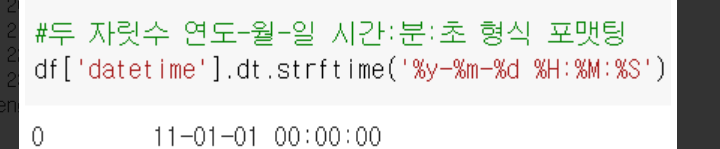

In [ ]:
pd.to_datetime(academy_student_workwheet_scoring_problem['ws_scoring.update_datetime']).dt.strftime('%y-%m-%d').head()

0    20-10-25
1    20-10-25
2    20-10-25
3    20-10-25
4    20-10-25
Name: ws_scoring.update_datetime, dtype: object

In [ ]:
# ws_scoring.update_datetime열이 조금 복잡하게 되어 있어서, 아래와 같이 데이터가 나오도록 했다.
# date = 날짜
# year = 연도

academy_student_workwheet_scoring_problem['date'] = pd.to_datetime(academy_student_workwheet_scoring_problem['ws_scoring.update_datetime']).dt.strftime('%y-%m-%d')
academy_student_workwheet_scoring_problem['year'] = pd.to_datetime(academy_student_workwheet_scoring_problem['ws_scoring.update_datetime']).dt.year

academy_student_workwheet_scoring_problem.loc[:,['ws_scoring.update_datetime', 'date', 'year']].head()

,ws_scoring.update_datetime,date,year
0,2020-10-25 15:08:06,20-10-25,2020
1,2020-10-25 15:12:47,20-10-25,2020
2,2020-10-25 15:08:06,20-10-25,2020
3,2020-10-25 15:12:47,20-10-25,2020
4,2020-10-25 15:08:06,20-10-25,2020


### recorded_grade열 추가

일단 년도의 경우에 2000, 2020, 2021, 2022로만 나오는데, 이 자체도 이상하다.

그리고 recorded_grade는 4로 나눈 나머지를 의미하기에 무엇을 나타내는 값인지는 잘 모르곘다.

In [ ]:
academy_student_workwheet_scoring_problem['recorded_grade'] = 0

academy_student_workwheet_scoring_problem['recorded_grade'] = academy_student_workwheet_scoring_problem['year'].apply(lambda x:x%4+1)
academy_student_workwheet_scoring_problem.loc[:,'recorded_grade'].value_counts()

2    6310791
3    1962496
1    1793513
Name: recorded_grade, dtype: int64

In [ ]:
academy_student_workwheet_scoring_problem['year'].value_counts()

2021    6310791
2022    1962496
2020    1792835
2000        678
Name: year, dtype: int64

In [ ]:
# # 저장

# academy_student_workwheet_scoring_problem.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring_problem.csv')

In [ ]:
# raw 데이터인 'student_worksheet_scoring'를 직접 처리해보아도,
# 똑같이 2000, 2020, 2021, 2022만 데이터가 있다.

student_worksheet_scoring.loc[:,'ws_scoring.update_datetime'].apply(lambda x : int(x.split()[0].split('-')[0])).value_counts()

2022    21922427
2021    20147119
2020     3574757
2000        2082
Name: ws_scoring.update_datetime, dtype: int64

## problem

In [ ]:
# problem 테이블과 관련되서 필요한 것들을 모두 가져왔다.

problem = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/problem.csv')
problem_concept = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/problem_concept.csv')
problem_curriculum = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/problem_curriculum.csv')
problem_curriculum_concept_cache = pd.read_csv('/content/drive/MyDrive/archive/sql_2_csv/problem_curriculum_concept_cache.csv')

In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

problem = problem[['id', 'problem_concept_id', 'group_code', 'level', 'type', 'correct_rate', 'create_datetime', 'update_datetime']]
problem.columns = ['p.id', 'p.problem_concept_id', 'p.group_code', 'p.level', 'p.type', 'p.correct_rate', 'p.create_datetime', 'p.update_datetime']
problem.head()

,p.id,p.problem_concept_id,p.group_code,p.level,p.type,p.correct_rate,p.create_datetime,p.update_datetime
0,1,1693,NaN,4,0,90.6250,2021-10-26 00:21:06,2022-07-13 12:30:47
1,2,1696,NaN,2,1,47.2868,2021-10-26 00:21:06,2022-09-20 11:23:31
2,3,1693,NaN,2,2,87.7953,2021-10-26 00:21:06,2022-09-20 11:24:16
3,4,1693,NaN,2,0,93.2990,2021-10-26 00:21:06,2022-09-20 11:24:16
4,5,1696,NaN,2,2,89.2473,2021-10-26 00:21:06,2022-09-20 11:24:16


## 5. academy_student_workwheet_scoring_problem_problem

***(academy + student + student_workwheet + student_worksheet_scoring + worksheet_problem + problem)***

'academy_student_workwheet_scoring_problem'이랑 'problem'를 합친다.

In [ ]:
academy_student_workwheet_scoring_problem_problem = pd.merge(academy_student_workwheet_scoring_problem, problem,
                                                             left_on='ws_problem.problem_id', right_on='p.id', how='inner')

academy_student_workwheet_scoring_problem_problem = academy_student_workwheet_scoring_problem_problem[['academy.id', 'academy.status', 'academy.create_datetime', 'academy.runway', 
                                                                       'student.id', 'student.school_type', 'student.grade', 'student.status', 
                                                                       's_ws.id', 's_ws.worksheet_id','s_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
                                                                       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
                                                                       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id', 'ws_problem.ordering_number','ws_problem.type',
                                                                       'date', 'year',
                                                                       'p.id', 'p.problem_concept_id', 'p.group_code', 'p.level', 'p.type', 'p.correct_rate', 'p.create_datetime', 'p.update_datetime']]
academy_student_workwheet_scoring_problem_problem.head()

In [ ]:
academy_student_workwheet_scoring_problem_problem.sort_values(by=['student.id', 'year']).head()

In [ ]:
# 저장

academy_student_workwheet_scoring_problem_problem.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring_problem_problem.csv')

## problem concept

In [ ]:
# 필요한 열들만 추출해서, 순서 바꾸고, 열이름도 바꿔주었다.

problem_concept = problem_concept[['id', 'problem_curriculum_id', 'school', 'grade','semester', 'name', 'sequence', 'correct_rate', 'create_datetime','update_datetime']]
problem_concept.columns = ['p_cpt.id', 'p_cpt.problem_curriculum_id', 'p_cpt.school', 'p_cpt.grade','p_cpt.semester', 'p_cpt.name', 'p_cpt.sequence', 'p_cpt.correct_rate', 'p_cpt.create_datetime','p_cpt.update_datetime']
problem_concept.head()


,p_cpt.id,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime
0,1,1,1,1,1,미분류,1,65.9813,2021-10-26 00:20:37,2021-10-26 00:20:37
1,2,2415,2,1,2,줄기와 잎 정하기,1,88.5755,2021-10-26 00:20:38,2021-10-26 00:20:38
2,3,2415,2,1,2,자료의 최고와 최저 구하기,2,90.8241,2021-10-26 00:20:38,2021-10-26 00:20:38
3,4,2415,2,1,2,줄기와 잎그림에서 조건에 맞게 빈칸 채우기,3,84.9490,2021-10-26 00:20:38,2021-10-26 00:20:38
4,5,2415,2,1,2,특정 줄기의 잎 찾기,4,94.4262,2021-10-26 00:20:38,2021-10-26 00:20:38


## 6. academy_student_workwheet_scoring_problem_problem_cpt

***(academy + student + student_workwheet + student_worksheet_scoring + worksheet_problem + problem + problem_concept)***

'academy_student_workwheet_scoring_problem_problem'이랑 'problem_concept'를 합친다.

In [ ]:
academy_student_workwheet_scoring_problem_problem_cpt = pd.merge(academy_student_workwheet_scoring_problem_problem, problem_concept,
                                                                 left_on='p.problem_concept_id', right_on='p_cpt.id', how='inner')
academy_student_workwheet_scoring_problem_problem_cpt = academy_student_workwheet_scoring_problem_problem_cpt[['academy.id', 'academy.status', 'academy.create_datetime', 'academy.runway', 
                                                                       'student.id', 'student.school_type', 'student.grade', 'student.status', 
                                                                       's_ws.id', 's_ws.worksheet_id','s_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
                                                                       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
                                                                       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id', 'ws_problem.ordering_number','ws_problem.type',
                                                                       'date', 'year',
                                                                       'p.id',  'p.group_code', 'p.level', 'p.type', 'p.correct_rate', 'p.create_datetime', 'p.update_datetime',
                                                                       'p_cpt.id', 'p_cpt.problem_curriculum_id', 'p_cpt.school', 'p_cpt.grade','p_cpt.semester', 'p_cpt.name', 'p_cpt.sequence', 'p_cpt.correct_rate', 'p_cpt.create_datetime','p_cpt.update_datetime']]
academy_student_workwheet_scoring_problem_problem_cpt.head()

,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,s_ws.worksheet_id,...,p_cpt.id,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime
0,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,5525992,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
1,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6915136,5525992,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
2,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6931764,5540742,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
3,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6931761,5540742,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
4,D0409,PAY_INPROGRESS,2017-03-02,2088,I15492,3,3,1,6931765,5540742,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39


In [ ]:
# # 저장

# academy_student_workwheet_scoring_problem_problem_cpt.to_csv('/content/drive/MyDrive/teamC/Namhun/academy_student_workwheet_scoring_problem_problem_cpt.csv')

# 3. 분석

## (전처리) 집계

In [ ]:
# 최종 데이터 불러오기
# 내가 만든 데이터

data = pd.read_csv('/content/drive/MyDrive/teamC/Namhun/data/academy_student_workwheet_scoring_problem_problem_cpt.csv')
data.head()

,Unnamed: 0,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,...,p_cpt.id,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime
0,0,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6915137,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
1,1,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6915136,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
2,2,D0409,PAY_INPROGRESS,2017-03-02,2088,I7951,3,3,1,6931764,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
3,3,D0409,PAY_INPROGRESS,2017-03-02,2088,I7983,3,3,0,6931761,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
4,4,D0409,PAY_INPROGRESS,2017-03-02,2088,I15492,3,3,1,6931765,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39


In [ ]:
data.columns

Index(['Unnamed: 0', 'academy.id', 'academy.status', 'academy.create_datetime',
       'academy.runway', 'student.id', 'student.school_type', 'student.grade',
       'student.status', 's_ws.id', 's_ws.worksheet_id',
       's_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id',
       'ws_problem.ordering_number', 'ws_problem.type', 'date', 'year', 'p.id',
       'p.group_code', 'p.level', 'p.type', 'p.correct_rate',
       'p.create_datetime', 'p.update_datetime', 'p_cpt.id',
       'p_cpt.problem_curriculum_id', 'p_cpt.school', 'p_cpt.grade',
       'p_cpt.semester', 'p_cpt.name', 'p_cpt.sequence', 'p_cpt.correct_rate',
       'p_cpt.create_datetime', 'p_cpt.update_datetime'],
      dtype='object')

In [ ]:
# 팔요없는 열 삭제

remove_col = ['Unnamed: 0', 'academy.status', 'student.school_type', 'student.grade']

data = data.drop(remove_col, axis=1)
data.shape

(10066800, 37)

In [ ]:
data.columns

Index(['academy.id', 'academy.create_datetime', 'academy.runway', 'student.id',
       'student.status', 's_ws.id', 's_ws.worksheet_id',
       's_ws.create_datetime', 's_ws.open_datetime', 's_ws.solve_datetime',
       'ws_scoring.id', 'ws_scoring.result', 'ws_scoring.update_datetime',
       'ws_problem.id', 'ws_problem.worksheet_id', 'ws_problem.problem_id',
       'ws_problem.ordering_number', 'ws_problem.type', 'date', 'year', 'p.id',
       'p.group_code', 'p.level', 'p.type', 'p.correct_rate',
       'p.create_datetime', 'p.update_datetime', 'p_cpt.id',
       'p_cpt.problem_curriculum_id', 'p_cpt.school', 'p_cpt.grade',
       'p_cpt.semester', 'p_cpt.name', 'p_cpt.sequence', 'p_cpt.correct_rate',
       'p_cpt.create_datetime', 'p_cpt.update_datetime'],
      dtype='object')

In [ ]:
# 제거를 했어도 서로 겹치는 것들이 꽤 있다.
# 일단 하나씩 찾아내는게 의미가 없음으로 필요한 것만 고르도록 하자.

# 'p.id' = 'ws_problem.problem_id'
(data.loc[:,'p.id'] - data.loc[:,'ws_problem.problem_id']).unique()

# 's_ws.worksheet_id' = 'ws_problem.worksheet_id'
(data.loc[:,'s_ws.worksheet_id'] - data.loc[:,'ws_problem.worksheet_id']).unique()

array([0])

In [ ]:
# 필요한 열만 선택!

data_imp = data.loc[:,['student.id', 's_ws.worksheet_id', 'ws_scoring.result', 'ws_scoring.update_datetime',
                       'p.id', 'p.level', 'p.type', 'p.correct_rate', 'p_cpt.grade']]
data_imp.head()

,student.id,s_ws.worksheet_id,ws_scoring.result,ws_scoring.update_datetime,p.id,p.level,p.type,p.correct_rate,p_cpt.grade
0,I7951,5525992,CORRECT,2020-10-25 15:08:06,252454,2,2,78.2441,1
1,I7983,5525992,CORRECT,2020-10-25 15:12:47,252454,2,2,78.2441,1
2,I7951,5540742,CORRECT,2020-10-15 20:19:03,252454,2,2,78.2441,1
3,I7983,5540742,CORRECT,2020-10-15 20:22:18,252454,2,2,78.2441,1
4,I15492,5540742,CORRECT,2020-10-21 18:54:48,252454,2,2,78.2441,1


In [ ]:
data_imp.columns = ['student_id', 'worksheet_id', 'result', 'worksheet_solve_date', 'p_id', 'p_level', 'p_type', 'p_correct_rate', 'p_grade']
data_imp.head(1)

,student_id,worksheet_id,result,worksheet_solve_date,p_id,p_level,p_type,p_correct_rate,p_grade
0,I7951,5525992,CORRECT,2020-10-25 15:08:06,252454,2,2,78.2441,1


In [ ]:
# 많이 푼 학생이나 오래 머문 학생

data_imp.groupby('student_id').worksheet_solve_date.nunique().value_counts()[:20]

1     1970
2     1326
3      875
4      774
5      644
6      541
7      495
8      470
10     372
9      366
11     353
12     330
14     280
15     272
13     260
16     219
18     214
17     205
19     183
20     168
Name: worksheet_solve_date, dtype: int64

In [ ]:
# 학생별, 년도별, 문제난이도별, 정답여부(correct, wrong)별로 갯수를 센다.

student_scoring_rate_per_year_level = academy_student_workwheet_scoring_problem_problem_cpt.groupby(
    ['student.id', 'year', 'p.level', 'ws_scoring.result'])['p.id'].count()

student_scoring_rate_per_year_level.head()

In [ ]:
type(student_scoring_rate_per_year_level) # 마지막 갯수가 유일한 열인 'Series'이다.

In [ ]:
# 보기 쉽도록 채점 결과(CORRECT, WRONG)인 'ws_scoring.result'를 열로 하는 데이터프레임으로 바꿔준다.

student_scoring_rate_per_year_level = pd.DataFrame(student_scoring_rate_per_year_level).pivot_table(
    index=['student.id','year', 'p.level'],
    columns='ws_scoring.result', values='p.id')

# NA -> 0
student_scoring_rate_per_year_level = student_scoring_rate_per_year_level.fillna(0)
student_scoring_rate_per_year_level.head()

In [ ]:
type(student_scoring_rate_per_year_level)

In [ ]:
student_scoring_rate_per_year_level.columns

In [ ]:
# 정답률(correct_rate)을 계산해서 새로운 열로 추가해준다.
# '학생별, 년도별, 문제 난이도별'로 전체 문제 중에서 맞춘 문제의 수

student_scoring_rate_per_year_level['correct_rate'] = student_scoring_rate_per_year_level['CORRECT'] / (student_scoring_rate_per_year_level['CORRECT'] + student_scoring_rate_per_year_level['WRONG'])
student_scoring_rate_per_year_level.head()

In [ ]:
# 데이터 분석이 쉽도록, groupby 때문에 index가 되었던 것들을 모두 columns으로 바꿔준다.

student_scoring_rate_per_year_level = student_scoring_rate_per_year_level.reset_index()
student_scoring_rate_per_year_level.head()

In [ ]:
student_scoring_rate_per_year_level.columns

In [ ]:
# 새로운 열 두가지('score', 'solve_num')를 추가해준다.
# score = '각 학생별, 년도별, 문제수준별'로 '정답률 x 문제수준'을 곱한 값 <- 클수록 학생의 성취도가 높은 것이다.(어려운 문제를 많이 맞춘 것임으로; 0~5)
# solve_num = '각 학생별, 년도별, 문제수준별'로 푼 문제의 수(CORRECT + WRONG)

student_scoring_rate_per_year_level['score'] = student_scoring_rate_per_year_level['correct_rate'] * student_scoring_rate_per_year_level['p.level']
student_scoring_rate_per_year_level['solve_num'] = student_scoring_rate_per_year_level['CORRECT'] + student_scoring_rate_per_year_level['WRONG']

student_scoring_rate_per_year_level.head()

In [ ]:
# 이제 여기서 학생별, 년도별로 더하는(sum) groupby를 해서
# score와 solve_num만 열로 가져온다.

student_scoring_rate_per_year_level_score = pd.DataFrame(student_scoring_rate_per_year_level.groupby(['student.id', 'year'])['score', 'solve_num'].sum())

# groupby결과 index가 된 것들을 다시 columns으로 바꿔준다.
student_scoring_rate_per_year_level_score = student_scoring_rate_per_year_level_score.reset_index()
student_scoring_rate_per_year_level_score.head()

In [ ]:
# # 저장

# student_scoring_rate_per_year_level_score.to_csv('/content/drive/MyDrive/teamC/Namhun/data/student_scoring_rate_per_year_level_score.csv')

## (전처리) 

In [ ]:
# 'student_scoring_rate_per_year_level_score' 불러오기

student_scoring_rate_per_year_level_score = pd.read_csv('/content/drive/MyDrive/teamC/Namhun/data/student_scoring_rate_per_year_level_score.csv')
student_scoring_rate_per_year_level_score.head()

,Unnamed: 0,student.id,year,score,solve_num
0,0,I100008,2020,9.348183,1628.0
1,1,I100008,2021,8.580949,3724.0
2,2,I100067,2020,10.129015,579.0
3,3,I100067,2021,11.962930,3165.0
4,4,I100067,2022,9.871144,622.0


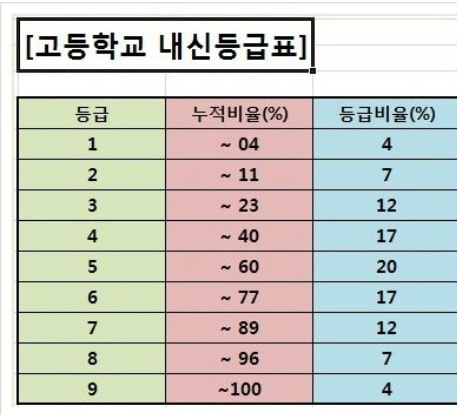

In [ ]:
def rating(x):
  if x <= 0.04:
    return 9
  elif x <= 0.11:
    return 8
  elif x <= 0.23:
    return 7
  elif x <= 0.40:
    return 6
  elif x <= 0.60:
    return 5
  elif x <= 0.77:
    return 4
  elif x <= 0.89:
    return 3
  elif x <= 0.96:
    return 2
  elif x <= 1.00:
    return 1              

In [ ]:
# 한빈형의 경우에 min,max로 (0,1) 사이의 값으로 변경해준 다음에
# 점수를 기준으로 등급을 부여했다.
# 그러나 실제 수능의 경우에는 상대평가임으로 '절대적인 점수'가 기준이 아닌 '상대적인 점수'가 고려되어야한다.
# 일단 똑같이 열을 한 번 만들어보고, 등급 처리 관련해서 내 방식('상대적인 점수')대로 한 열을 추가하자!
# 또, 고려해야할 것이 있는데 년도별로 같은 년도에만 비교를 해야한다는 것이다!

# 점수를 기준으로 분류하기 위해, (0,1) 사이로 점수를 모두 바꾸어준다.
from sklearn.preprocessing import MinMaxScaler

scaler_ = MinMaxScaler()

# solve_num -> scaled_solve_num
scaler_.fit(pd.DataFrame(student_scoring_rate_per_year_level_score['solve_num']))
student_scoring_rate_per_year_level_score['scaled_solve_num'] = scaler_.transform(pd.DataFrame(student_scoring_rate_per_year_level_score['solve_num']))

# score -> scaled_score
scaler_.fit(pd.DataFrame(student_scoring_rate_per_year_level_score['score']))
student_scoring_rate_per_year_level_score['scaled_score'] = scaler_.transform(pd.DataFrame(student_scoring_rate_per_year_level_score['score']))

In [ ]:
# # 이제 이 만든 점수들을 가지고, 등급을 부여해준다. <- 나는 다시 만들자.
# student_scoring_rate_per_year_level_score['score_rating'] = student_scoring_rate_per_year_level_score['scaled_score']
# student_scoring_rate_per_year_level_score['score_rating'] = student_scoring_rate_per_year_level_score['score_rating'].apply(rating)

# student_scoring_rate_per_year_level_score['solve_num_rating'] = student_scoring_rate_per_year_level_score['scaled_solve_num']
# student_scoring_rate_per_year_level_score['solve_num_rating'] = student_scoring_rate_per_year_level_score['solve_num_rating'].apply(rating)

In [ ]:
# 1. 년도별로 나눈다.

student_scoring_rate_per_year_level_score.loc[:,'year'].value_counts() # 2000년은 너무 오래된 데이터임으로 제거하자.

2021    11252
2020     7020
2022     4018
2000      511
Name: year, dtype: int64

In [ ]:
student_scoring_rate_per_year_level_score.head(1)

,Unnamed: 0,student.id,year,score,solve_num
0,0,I100008,2020,9.348183,1628.0


In [ ]:
idx = np.where(student_scoring_rate_per_year_level_score.loc[:,'year']==2000)[0]
idx

In [ ]:

id = student_scoring_rate_per_year_level_score.loc[idx,'student.id']
id

168      I106814
214      I108759
229      I108992
240      I109215
347      I112737
          ...   
22661     I95909
22669     I96048
22730     I98070
22750     I98617
22783     I99616
Name: student.id, Length: 511, dtype: object

In [ ]:
student_scoring_rate_per_year_level_score.loc[:,'student.id'].apply(lambda x: 1 if x in id else 0).value_counts()

0    22290
Name: student.id, dtype: int64

In [ ]:
# 2000년 제거

import numpy as np

idx1 = np.where(student_scoring_rate_per_year_level_score.loc[:,'year'].values != 2000)[0]
student_scoring_rate_per_year_level_score = student_scoring_rate_per_year_level_score.iloc[idx1,:]
student_scoring_rate_per_year_level_score.loc[:,'year'].value_counts()

2021    11252
2020     7020
2022     4018
Name: year, dtype: int64

In [ ]:
# 202

student_scoring_rate_per_year_level_score.head()


,Unnamed: 0,student.id,year,score,solve_num
0,0,I100008,2020,9.348183,1628.0
1,1,I100008,2021,8.580949,3724.0
2,2,I100067,2020,10.129015,579.0
3,3,I100067,2021,11.962930,3165.0
4,4,I100067,2022,9.871144,622.0


In [ ]:
student_scoring_rate_per_year_level_score.groupby(['student.id']).year.count().value_counts()

1    10417
2     4840
3      731
Name: year, dtype: int64

array([2020, 2021, 2020, ..., 2021, 2021, 2021])

In [ ]:
student_scoring_rate_per_year_level_score.loc[]:,'year')

SyntaxError: ignored

In [ ]:
# method='average'; 동점자는 가운데 등수로 같게 처리
# ascending=False; 점수가 높으면, 등수가 빠르다.

student_scoring_rate_per_year_level_score['score_rating1'] = student_scoring_rate_per_year_level_score['solve_num'].rank(method='average', ascending=False)

student_scoring_rate_per_year_level_score.head(2)


ws_scoring.result,student.id,year,score,solve_num,scaled_solve_num,scaled_score,score_rating,solve_num_rating
0,I100008,2020,9.348183,1628.0,0.117609,0.623212,4,7
1,I100008,2021,8.580949,3724.0,0.269120,0.572063,5,6
2,I100067,2020,10.129015,579.0,0.041781,0.675268,4,8
3,I100067,2021,11.962930,3165.0,0.228712,0.797529,3,7
4,I100067,2022,9.871144,622.0,0.044889,0.658076,4,8
...,...,...,...,...,...,...,...,...
22796,I99963,2021,7.510823,90.0,0.006433,0.500722,5,9
22797,IB113,2020,5.977778,40.0,0.002819,0.398519,6,9
22798,IB113,2021,6.595556,48.0,0.003397,0.439704,5,9
22799,IB123,2021,7.862458,283.0,0.020385,0.524164,5,9


In [ ]:
# 2020
# sns.scatterplot(data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] == 2020], x="scaled_score", y="scaled_solve_num")
sns.lmplot(x="scaled_score", y="scaled_solve_num", 
           data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] == 2020], 
           line_kws={'color':"red"},scatter_kws={'edgecolor':"white"}, hue = 'score_rating')

NameError: ignored

In [ ]:
from statsmodels.formula.api import ols

res = ols('scaled_score ~ scaled_solve_num', 
          data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] == 2020]).fit() 
res.summary()

In [ ]:
# 2021
# sns.scatterplot(data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] == 2021], x="scaled_score", y="scaled_solve_num", )
sns.lmplot(x="scaled_score", y="scaled_solve_num", 
           data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] == 2021], 
           line_kws={'color':"red"},scatter_kws={'edgecolor':"white"}, hue = 'score_rating')

In [ ]:
# 2022
# sns.scatterplot(data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] == 2022], x="scaled_score", y="scaled_solve_num", )
sns.lmplot(x="scaled_score", y="scaled_solve_num", 
           data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] == 2022], 
           line_kws={'color':"red"},scatter_kws={'edgecolor':"white"}, hue = 'score_rating')

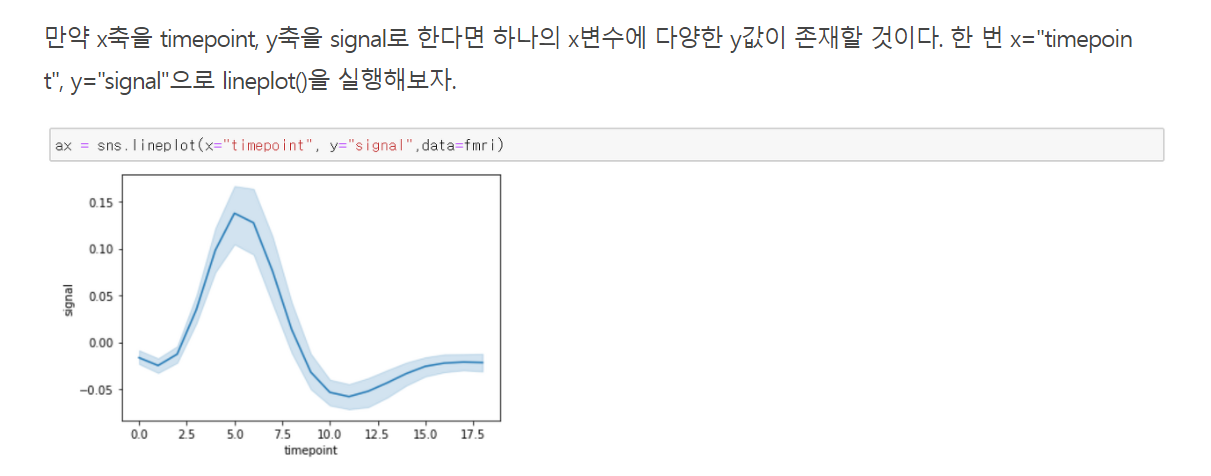

In [ ]:
sns.lineplot(x="year", y="scaled_score", 
           data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] != 2000])
           #,hue = 'score_rating')

In [ ]:
sns.lineplot(x="year", y="scaled_score", 
           data=student_scoring_rate_per_year_level_score[student_scoring_rate_per_year_level_score['year'] != 2000]
           ,hue = 'score_rating')

In [ ]:
import matplotlib.pyplot as plt

plt.ylim(0.0, 1.0)
sns.lineplot(x="year", y="scaled_score", 
           data=student_scoring_rate_per_year_level_score[(student_scoring_rate_per_year_level_score['student.id'] == 'I100008') | (student_scoring_rate_per_year_level_score['student.id'] == 'IB113')],
           hue = 'student.id')

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(32,8)})
sns.boxplot(x = student_scoring_rate_per_year_level_score["score_rating"], 
            y=student_scoring_rate_per_year_level_score["scaled_solve_num"],  
            hue = student_scoring_rate_per_year_level_score['year'])



## 일자별 scoring

In [ ]:
def rating(x):
  if x <= 0.04:
    return 9
  elif x <= 0.11:
    return 8
  elif x <= 0.23:
    return 7
  elif x <= 0.40:
    return 6
  elif x <= 0.60:
    return 5
  elif x <= 0.77:
    return 4
  elif x <= 0.89:
    return 3
  elif x <= 0.96:
    return 2
  elif x <= 1.00:
    return 1   

In [ ]:
academy_student_workwheet_scoring_problem_problem_cpt

,Unnamed: 0,academy.id,academy.status,academy.create_datetime,academy.runway,student.id,student.school_type,student.grade,student.status,s_ws.id,...,p_cpt.id,p_cpt.problem_curriculum_id,p_cpt.school,p_cpt.grade,p_cpt.semester,p_cpt.name,p_cpt.sequence,p_cpt.correct_rate,p_cpt.create_datetime,p_cpt.update_datetime
0,0,D0409,PAY_INPROGRESS,2017-03-02,2086,I7951,3,3,1,6915137,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
1,1,D0409,PAY_INPROGRESS,2017-03-02,2086,I7983,3,3,0,6915136,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
2,2,D0409,PAY_INPROGRESS,2017-03-02,2086,I7951,3,3,1,6931764,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
3,3,D0409,PAY_INPROGRESS,2017-03-02,2086,I7983,3,3,0,6931761,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
4,4,D0409,PAY_INPROGRESS,2017-03-02,2086,I15492,3,3,1,6931765,...,7471,3316,3,1,1,원의 방정식의 표준형에서 중심과 반지름,1,55.8022,2021-10-26 00:20:39,2021-10-26 00:20:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10066302,10066302,D11960,PAY_INPROGRESS,2021-06-24 10:40:15,510,I342262,3,3,0,14412532,...,3575,3653,3,3,1,미분가능일 조건,3,63.4014,2021-10-26 00:20:39,2021-10-26 00:20:39
10066303,10066303,D11960,PAY_INPROGRESS,2021-06-24 10:40:15,510,I342262,3,3,0,14412532,...,3575,3653,3,3,1,미분가능일 조건,3,63.4014,2021-10-26 00:20:39,2021-10-26 00:20:39
10066304,10066304,D4969,PAY_INPROGRESS,2019-04-01 00:00:00,1326,I438579,3,3,0,14455719,...,2577,3524,3,1,1,공통근을 갖는 이차방정식,7,55.8360,2021-10-26 00:20:39,2021-10-26 00:20:39
10066305,10066305,D8216,PAY_INPROGRESS,2020-04-02 00:00:00,959,I203077,3,3,1,14618044,...,3060,3604,3,2,1,∞/∞ 꼴의 극한; 로그를 포함한 식,3,53.0114,2021-10-26 00:20:39,2021-10-26 00:20:39


In [ ]:
student_scoring_rate_per_year_level = academy_student_workwheet_scoring_problem_problem_cpt.groupby(['student.id', 'year', 'date', 'p.level', 'ws_scoring.result'])['p.id'].count()
student_scoring_rate_per_year_level = pd.DataFrame(student_scoring_rate_per_year_level).pivot_table(index=['student.id','year', 'date', 'p.level'], columns='ws_scoring.result', values='p.id')
student_scoring_rate_per_year_level = student_scoring_rate_per_year_level.fillna(0)
student_scoring_rate_per_year_level['correct_rate'] = student_scoring_rate_per_year_level['CORRECT'] / (student_scoring_rate_per_year_level['CORRECT'] + student_scoring_rate_per_year_level['WRONG'])
student_scoring_rate_per_year_level = student_scoring_rate_per_year_level.reset_index()
student_scoring_rate_per_year_level['score'] = student_scoring_rate_per_year_level['correct_rate'] * student_scoring_rate_per_year_level['p.level']
student_scoring_rate_per_year_level['solve_num'] = student_scoring_rate_per_year_level['CORRECT'] + student_scoring_rate_per_year_level['WRONG']

student_scoring_rate_per_year_level_score = pd.DataFrame(student_scoring_rate_per_year_level.groupby(['student.id','year', 'date'])['score', 'solve_num'].sum())
student_scoring_rate_per_year_level_score = student_scoring_rate_per_year_level_score.reset_index()

from sklearn.preprocessing import MinMaxScaler
scaler_ = MinMaxScaler()
scaler_.fit(pd.DataFrame(student_scoring_rate_per_year_level_score['solve_num']))
student_scoring_rate_per_year_level_score['scaled_solve_num'] = scaler_.transform(pd.DataFrame(student_scoring_rate_per_year_level_score['solve_num']))


scaler_.fit(pd.DataFrame(student_scoring_rate_per_year_level_score['score']))
student_scoring_rate_per_year_level_score['scaled_score'] = scaler_.transform(pd.DataFrame(student_scoring_rate_per_year_level_score['score']))


student_scoring_rate_per_year_level_score['score_rating'] = student_scoring_rate_per_year_level_score['scaled_score']
student_scoring_rate_per_year_level_score['score_rating'] = student_scoring_rate_per_year_level_score['score_rating'].apply(rating)


student_scoring_rate_per_year_level_score['solve_num_rating'] = student_scoring_rate_per_year_level_score['scaled_solve_num']
student_scoring_rate_per_year_level_score['solve_num_rating'] = student_scoring_rate_per_year_level_score['solve_num_rating'].apply(rating)


student_scoring_rate_per_year_level_score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


ws_scoring.result,student.id,year,date,score,solve_num,scaled_solve_num,scaled_score,score_rating,solve_num_rating
0,I100008,2020,20-11-07,3.954545,20.0,0.012960,0.263636,6,9
1,I100008,2020,20-11-14,4.403175,27.0,0.017735,0.293545,6,9
2,I100008,2020,20-11-16,8.625000,12.0,0.007503,0.575000,5,9
3,I100008,2020,20-11-18,7.844156,20.0,0.012960,0.522944,5,9
4,I100008,2020,20-11-20,2.000000,2.0,0.000682,0.133333,7,9
...,...,...,...,...,...,...,...,...,...
289690,IB113,2021,21-01-23,6.166667,18.0,0.011596,0.411111,5,9
289691,IB113,2021,21-03-19,7.137500,30.0,0.019782,0.475833,5,9
289692,IB123,2021,21-02-18,8.341492,140.0,0.094816,0.556099,5,8
289693,IB123,2021,21-03-30,5.722511,143.0,0.096862,0.381501,6,8


In [ ]:
import matplotlib.pyplot as plt

#plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
sns.lineplot(x="date", y="score", 
           data=student_scoring_rate_per_year_level_score[(student_scoring_rate_per_year_level_score['student.id'] == 'I100008') | (student_scoring_rate_per_year_level_score['student.id'] == 'IB113')],
           hue = 'student.id')


## 누적 일자별 score

In [ ]:
student_scoring_rate_per_year_level = academy_student_workwheet_scoring_problem_problem_cpt.groupby(['student.id', 'year', 'date', 'p.level', 'ws_scoring.result'])['p.id'].count()
student_scoring_rate_per_year_level = pd.DataFrame(student_scoring_rate_per_year_level).pivot_table(index=['student.id','year', 'date', 'p.level'], columns='ws_scoring.result', values='p.id')
student_scoring_rate_per_year_level = student_scoring_rate_per_year_level.fillna(0)
student_scoring_rate_per_year_level['correct_rate'] = student_scoring_rate_per_year_level['CORRECT'] / (student_scoring_rate_per_year_level['CORRECT'] + student_scoring_rate_per_year_level['WRONG'])
student_scoring_rate_per_year_level = student_scoring_rate_per_year_level.reset_index()
student_scoring_rate_per_year_level['score'] = student_scoring_rate_per_year_level['correct_rate'] * student_scoring_rate_per_year_level['p.level']
student_scoring_rate_per_year_level['solve_num'] = student_scoring_rate_per_year_level['CORRECT'] + student_scoring_rate_per_year_level['WRONG']
# student_scoring_rate_per_year_level['cumulative_correct'] = 0
# student_scoring_rate_per_year_level['cumulative_wrong'] = 0





student_scoring_rate_per_year_level

ws_scoring.result,student.id,year,date,p.level,CORRECT,WRONG,correct_rate,score,solve_num
0,I100008,2020,20-11-07,2,8.0,3.0,0.727273,1.454545,11.0
1,I100008,2020,20-11-07,3,1.0,5.0,0.166667,0.500000,6.0
2,I100008,2020,20-11-07,4,1.0,1.0,0.500000,2.000000,2.0
3,I100008,2020,20-11-07,5,0.0,1.0,0.000000,0.000000,1.0
4,I100008,2020,20-11-14,2,6.0,1.0,0.857143,1.714286,7.0
...,...,...,...,...,...,...,...,...,...
994131,IB163,2021,21-03-18,1,11.0,0.0,1.000000,1.000000,11.0
994132,IB163,2021,21-03-18,2,74.0,10.0,0.880952,1.761905,84.0
994133,IB163,2021,21-03-18,3,115.0,20.0,0.851852,2.555556,135.0
994134,IB163,2021,21-03-18,4,30.0,9.0,0.769231,3.076923,39.0


In [ ]:
# 진짜 오래 걸린다.

# student_date_dict = {}

# student_unique_list  = student_scoring_rate_per_year_level['student.id'].unique()
# for i in tqdm(range(len(student_unique_list))):
#   student_date_dict[str(student_unique_list[i])] = student_scoring_rate_per_year_level[student_scoring_rate_per_year_level['student.id']== student_unique_list[i]]['date'].unique()
# student_date_dict

In [ ]:
# student_date_dict 저장

import pickle
with open('/content/drive/MyDrive/teamC/Namhun/student_date_dict.pkl', 'wb') as f:
  pickle.dump(student_date_dict, f)

In [ ]:
'''
def cumulative_sum(x):
  cumulative_correct = 0 
  cumulative_wrong = 0
  for student in student_date_dict.keys:
    for date in student_date_dict[student]:
      cumulative_correct += student_scoring_rate_per_year_level[student_scoring_rate_per_year_level['date'] == date]['CORRECT']
      cumulative_wrong += student_scoring_rate_per_year_level[student_scoring_rate_per_year_level['date'] == date]['WRONG']
'''    


# 속도 향상을 위한 재귀 함수
def cumulative_sum_correct(student_id, date):
    cumulative_correct = 0 
    if date == student_date_dict[student_id][0]:
       cumulative_correct += student_scoring_rate_per_year_level[student_scoring_rate_per_year_level['date'] == date]['CORRECT']
       return cumulative_correct

    else:
      date_index = student_date_dict[student_id].index(student_date_dict[student_id][date])
      date = student_date_dict[student_id][date_index-1]
      cumulative_sum_correct(student_id, date)

def cumulative_sum_wrong(student_id, date):
    cumulative_wrong = 0 
    if date == student_date_dict[student_id][0]:
       cumulative_wrong += student_scoring_rate_per_year_level[student_scoring_rate_per_year_level['date'] == date]['WRONG']
       return cumulative_wrong

    else:
      date_index = student_date_dict[student_id].index(student_date_dict[student_id][date])
      date = student_date_dict[student_id][date_index-1]
      cumulative_sum_wrong(student_id, date)

In [ ]:
dummy = student_scoring_rate_per_year_level[:30]
dummy

In [ ]:
df = pd.DataFrame(np.array([['a', 1, 4], ['a', 2, 5], ['b', 3, 6]]),
                   columns=['col1', 'col2', 'col3'])

In [ ]:
def multiple_inouts(row):
    if row['col1'] == 'a':  # 'a'일 때, col2 10으로 나눈 후 부호반대
        col2 =  -float(row['col2'])/10
        col3 = row['col3']
    else:
        col2 = row['col2']  # 'b'일 때, col3 값 X 100 
        col3 = int(row['col3'])*100
        
    return [col2, col3]

In [ ]:
def cumulative_sum_correct(row):
  if row['student.id'] == student_date_dict.keys[0]:
    cumulative_correct = 0 
    if row['date'] == student_date_dict[ student_date_dict.keys[0] ][0]:
      cumulative_correct += row['CORRECT']
      return cumulative_correct
    else: 
      date_index = student_date_dict[ student_date_dict.keys[0] ].index(student_date_dict[ student_date_dict.keys[0] ][row['date']])
      row['date'] = student_date_dict[ student_date_dict.keys[0] ][date_index-1]


In [ ]:
student_date_dict

In [ ]:
list(student_date_dict['I100008']).index('20-11-07')

In [ ]:
# 속도 향상을 위한 재귀 함수
def cumulative_sum_correct(row):
    cumulative_correct = 0 
    if row['date'] == student_date_dict[row['student.id']][0]:
       cumulative_correct += row['CORRECT']
       return cumulative_correct

    else:
      date_index = list(student_date_dict[row['student.id']]).index(row['date'])
      row['date'] = student_date_dict[row['student.id']][date_index-1]
      cumulative_sum_correct(row)

In [ ]:
dummy['cumulative_correct'] = dummy.apply(lambda x: cumulative_sum_correct(x), axis=1, result_type='expand')
dummy

In [ ]:
df[['new_col2', 'new_col3']] = df.apply(lambda x: multiple_inouts(x), axis=1, result_type='expand')
print(df)


>>>> col1 col2 col3 new_col2 new_col3
  0    a    1    4     -0.1        4
  1    a    2    5     -0.2        5
  2    b    3    6        3      600

In [ ]:
# 속도 향상을 위한 재귀 함수
def cumulative_sum_correct(student_id, date):
    cumulative_correct = 0 
    if date == student_date_dict[student_id][0]:
       cumulative_correct += student_scoring_rate_per_year_level[student_scoring_rate_per_year_level['date'] == date]['CORRECT']
       return cumulative_correct

    else:
      date_index = student_date_dict[student_id].index(student_date_dict[student_id][date])
      date = student_date_dict[student_id][date_index-1]
      cumulative_sum_correct(student_id, date)

In [ ]:
student_scoring_rate_per_year_level_score = pd.DataFrame(student_scoring_rate_per_year_level.groupby(['student.id','year', 'date'])['score', 'solve_num'].sum())
student_scoring_rate_per_year_level_score = student_scoring_rate_per_year_level_score.reset_index()

from sklearn.preprocessing import MinMaxScaler
scaler_ = MinMaxScaler()
scaler_.fit(pd.DataFrame(student_scoring_rate_per_year_level_score['solve_num']))
student_scoring_rate_per_year_level_score['scaled_solve_num'] = scaler_.transform(pd.DataFrame(student_scoring_rate_per_year_level_score['solve_num']))


scaler_.fit(pd.DataFrame(student_scoring_rate_per_year_level_score['score']))
student_scoring_rate_per_year_level_score['scaled_score'] = scaler_.transform(pd.DataFrame(student_scoring_rate_per_year_level_score['score']))


student_scoring_rate_per_year_level_score['score_rating'] = student_scoring_rate_per_year_level_score['scaled_score']
student_scoring_rate_per_year_level_score['score_rating'] = student_scoring_rate_per_year_level_score['score_rating'].apply(rating)


student_scoring_rate_per_year_level_score['solve_num_rating'] = student_scoring_rate_per_year_level_score['scaled_solve_num']
student_scoring_rate_per_year_level_score['solve_num_rating'] = student_scoring_rate_per_year_level_score['solve_num_rating'].apply(rating)

student_scoring_rate_per_year_level_score

## problem 구체 정보

In [ ]:
problem_curriculum

,Unnamed: 0,id,parent_id,name,sequence,create_datetime,update_datetime
0,0,1,NaN,math,1,2021-10-26 00:19:33,2021-10-26 00:19:33
1,1,2,1.0,교육과정 15,1,2021-10-26 00:19:33,2021-10-26 00:19:33
2,2,3,1.0,교육과정 9,2,2021-10-26 00:19:33,2021-10-26 00:19:33
3,3,5,2.0,초등학교,1,2021-10-26 00:19:33,2021-10-26 00:19:33
4,4,6,3.0,초등학교,1,2021-10-26 00:19:33,2021-10-26 00:19:33
...,...,...,...,...,...,...,...
770,770,3767,1152.0,최소시간,1,2021-10-26 00:19:34,2021-10-26 00:19:34
771,771,3768,1153.0,통계,1,2021-10-26 00:19:34,2021-10-26 00:19:34
772,772,3769,1154.0,포함배제의 원리,1,2021-10-26 00:19:34,2021-10-26 00:19:34
773,773,3770,1155.0,행렬,1,2021-10-26 00:19:34,2021-10-26 00:19:34


In [ ]:
problem_curriculum_concept_cache

,Unnamed: 0,trie_key,relation_type,relation_id,relation_name,relation_sequence,revision_id,revision_name,school_id,school_name,...,subject_id,subject_name,big_chapter_id,big_chapter_name,middle_chapter_id,middle_chapter_name,little_chapter_id,little_chapter_name,concept_id,concept_name
0,0,1,MATH,1,math,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.2,REVISION,2,교육과정 15,1,2.0,교육과정 15,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.2.7,SCHOOL,7,고등학교,13,2.0,교육과정 15,7.0,고등학교,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.2.7.41,SUBJECT,41,고등수학(상),1301,2.0,교육과정 15,7.0,고등학교,...,41.0,고등수학(상),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1.2.7.41.368,BIG_CHAPTER,368,다항식,130101,2.0,교육과정 15,7.0,고등학교,...,41.0,고등수학(상),368.0,다항식,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3921,3921,1.3.8.40.448,BIG_CHAPTER,448,회전체부피,230730,3.0,교육과정 9,8.0,고등학교,...,40.0,교육과정 외,448.0,회전체부피,NaN,NaN,NaN,NaN,NaN,NaN
3922,3922,1.3.8.40.448.1156,MIDDLE_CHAPTER,1156,회전체부피,23073001,3.0,교육과정 9,8.0,고등학교,...,40.0,교육과정 외,448.0,회전체부피,1156.0,회전체부피,NaN,NaN,NaN,NaN
3923,3923,1.3.8.40.448.1156.3771,LITTLE_CHAPTER,3771,회전체부피,2307300101,3.0,교육과정 9,8.0,고등학교,...,40.0,교육과정 외,448.0,회전체부피,1156.0,회전체부피,3771.0,회전체부피,NaN,NaN
3924,3924,1.3.8.40.448.1156.3771:3890,CONCEPT,3890,회전체부피,230730010101,3.0,교육과정 9,8.0,고등학교,...,40.0,교육과정 외,448.0,회전체부피,1156.0,회전체부피,3771.0,회전체부피,3890.0,회전체부피


In [ ]:
student_worksheet_scoring = pd.read_csv('/content/drive/MyDrive/teamC/Hanbin/data/student_worksheet_scoring.csv')

In [ ]:
student_worksheet_scoring

,Unnamed: 0,ws_scoring.id,ws_scoring.student_worksheet_id,ws_scoring.worksheet_problem_id,ws_scoring.result,ws_scoring.update_datetime
0,0,22673,6915137,146873314,CORRECT,2020-10-25 15:08:06
1,1,22674,6915137,146873315,WRONG,2020-10-25 15:08:06
2,2,22675,6915137,146873316,WRONG,2020-10-25 15:08:06
3,3,22676,6915137,146873317,WRONG,2020-10-25 15:08:06
4,4,22677,6915137,146873318,WRONG,2020-10-25 15:08:06
...,...,...,...,...,...,...
45646380,94512570,649426499,27875198,649069800,CORRECT,2022-10-14 00:05:51
45646381,94512571,649426500,27875198,649069801,WRONG,2022-10-14 00:05:51
45646382,94512572,649426501,27875198,649069802,CORRECT,2022-10-14 00:05:51
45646383,94512573,649426502,27875198,649069803,CORRECT,2022-10-14 00:05:51
